In [1]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

## 6. In this exercise, you will further analyze the Wage data set considered throughout this chapter.

### (a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [2]:
wage_df = pd.read_csv('./data/Wage.csv')
wage_df = wage_df.drop(wage_df.columns[0], axis=1)

wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### Cross val

In [3]:
def ols_cv(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)


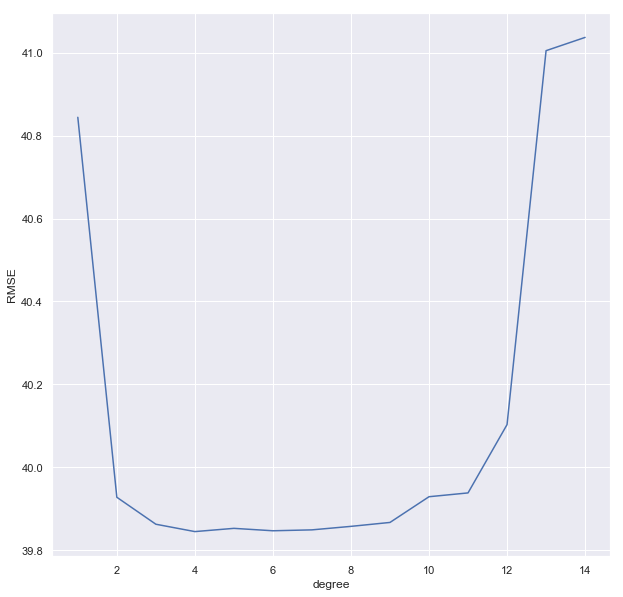

Min RMSE : 39.84520702156631
Degree   : 4


In [4]:
# Perform CV for increasing polynomial order
results = [] 
for d in np.arange(1,15):
    f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, d+1)])
    X = pt.dmatrix(f, wage_df)
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], d)]
    
# Plot the results
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'degree': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='degree', y='RMSE', data=df, color='b', ax=ax)
plt.show();

# Choose model
print('Min RMSE : {}'.format(min(results)[0]))
print('Degree   : {}'.format(min(results)[1]))

### ANOVA

In [5]:
# Derive 5 degree polynomial features of age
degree = 5
f = ' + '.join(['np.power(age, {})'.format(i) for i in np.arange(1, degree+1)])
X = pt.dmatrix(f, wage_df)
y = np.asarray(wage_df['wage'])

# Get models of increasing degrees
model_1 = sm.OLS(y, X[:, 0:2]).fit()
model_2 = sm.OLS(y, X[:, 0:3]).fit()
model_3 = sm.OLS(y, X[:, 0:4]).fit()
model_4 = sm.OLS(y, X[:, 0:5]).fit()
model_5 = sm.OLS(y, X[:, 0:6]).fit()

# Compare models with ANOVA
display(sm.stats.anova_lm(model_1, model_2, model_3, model_4, model_5))

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


**Comment:** Cross validation chooses a 4th degree polynomial model. Anova selects the 3rd degree model which scores only marginally below optimal in cross validation. It would be interesting to see which performs best in test.

### (b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of the fit obtained.

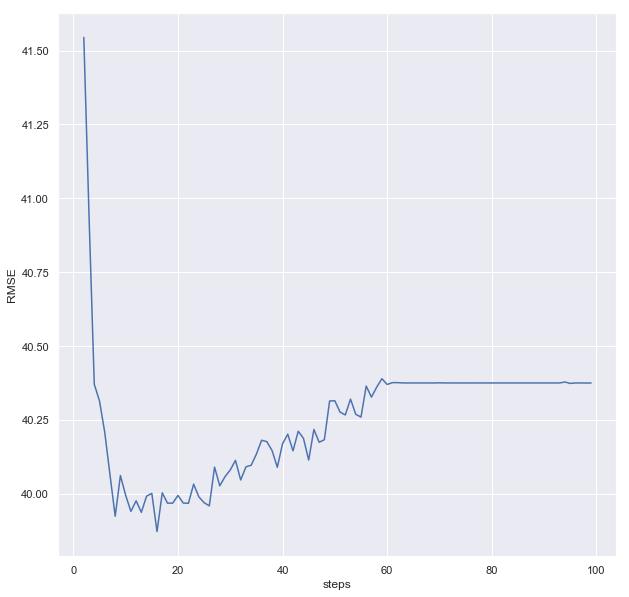

Min RMSE : 39.872054703507914
Steps   : 16


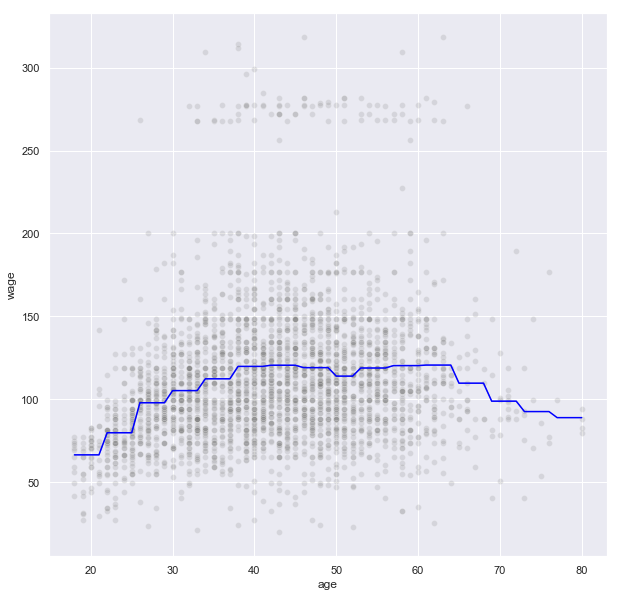

In [6]:
# CHOOSE BEST MODEL
# ----------------------------------

results = [] 
for steps in np.arange(2,100):
    # Segment data into 4 segments by age
    cuts = pd.cut(wage_df['age'], steps)
    X = np.asarray(pd.get_dummies(cuts))
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], steps)]
    
# Plot the results
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'steps': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='steps', y='RMSE', data=df, color='b', ax=ax)
plt.show();

# Choose model
print('Min RMSE : {}'.format(min(results)[0]))
print('Steps   : {}'.format(min(results)[1]))


# PLOT BEST MODEL
# ----------------------------------
steps = min(results)[1]

# Segment data into 4 segments by age
cuts = pd.cut(wage_df['age'], steps)
X = np.asarray(pd.get_dummies(cuts))
y = np.asarray(wage_df['wage'])

# Fit logistic regression model
model = sm.OLS(y, X).fit(disp=0)
y_hat = model.predict(X)


# Setup axes
fig, ax = plt.subplots(figsize=(10,10))

# Plot datapoints
sns.scatterplot(x='age', y='wage',
                color='tab:gray',
                alpha=0.2,
                ax=ax,
                data=pd.concat([wage_df['age'], wage_df['wage']], axis=1));

# Plot estimated f(x)
sns.lineplot(x=wage_df['age'], y=y_hat, ax=ax, color='blue')
plt.show();

## 7. The Wage data set contains a number of other features not explored in this chapter, such as marital status (maritl), job class (jobclass), and others. Explore the relationships between some of these other predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

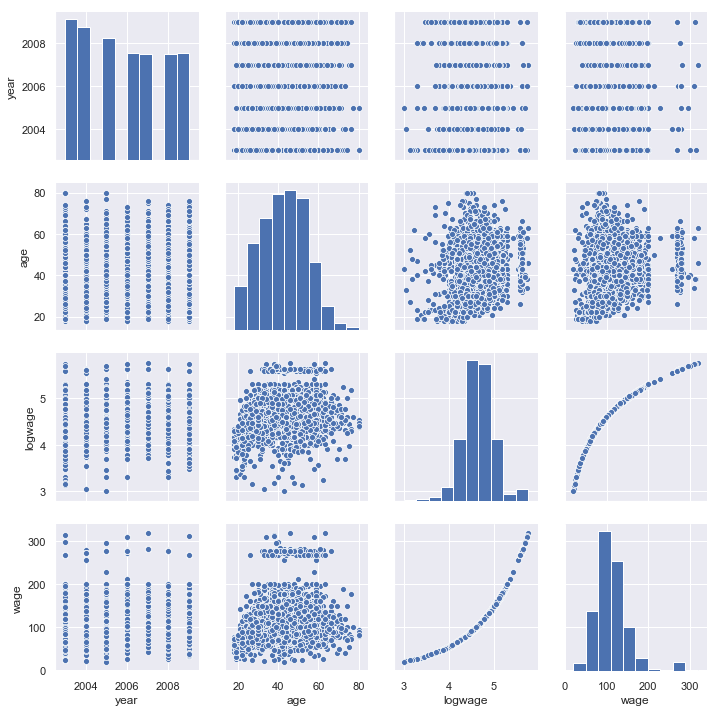

In [7]:
sns.pairplot(data=wage_df);

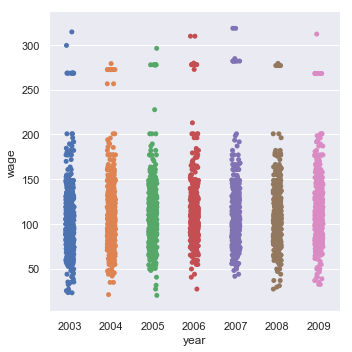

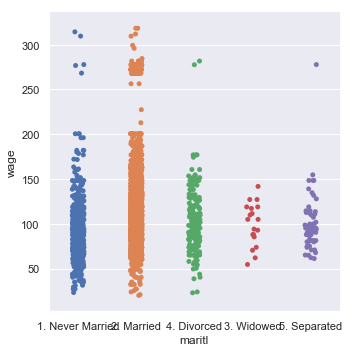

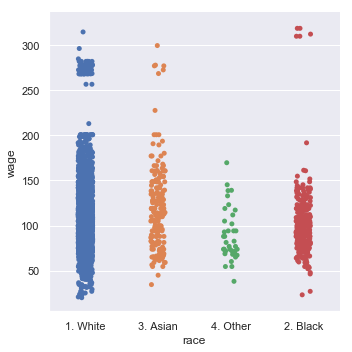

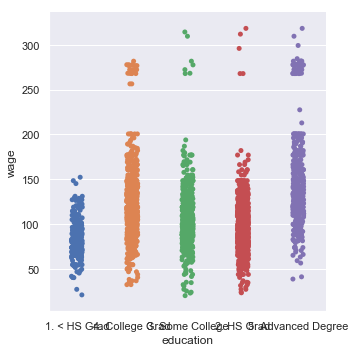

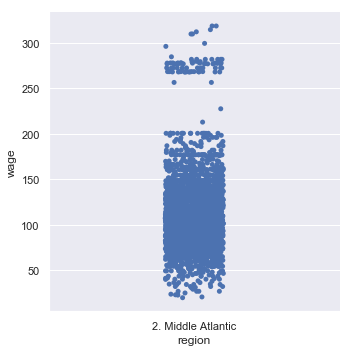

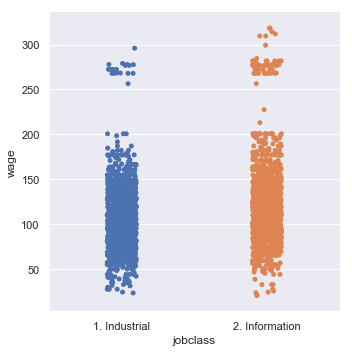

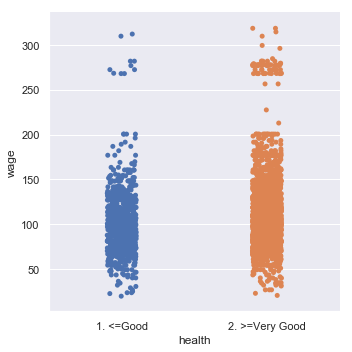

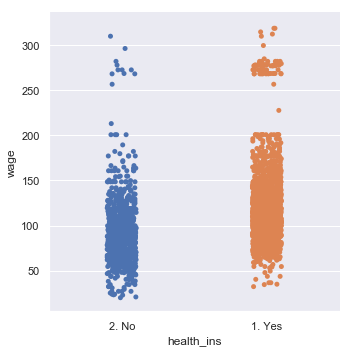

In [8]:
categoricals = wage_df.drop(['age', 'logwage', 'wage'], axis=1).columns
for c in categoricals:
    sns.catplot(x=c, y='wage', data=wage_df)

Notes:

- region only has one value so should be ignored
- health and health_ins look quite similar so only one of those might be needed
- age we know from above that 4 degree polynomial models well
- education we know from lab is best modelled as linear
- log wage is just log of wage so we'll drop it


In [9]:
wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### So how to find the best model?

We know that:

- age is nonlinear 
- education is fairly linear
- year is linear
- logwage, and region can be ignored
- the rest are linear dummy variables


Approaches I can think of:

- come up with some rang of models with different features and degrees of freedom then compare
- find the best model for each predictor feature indivivudally (slow) then combine with a GAM
- create a big GAM with basis functions appropriate to what is known so far, then perform backward stepwise selection

Let's try the latter.


In [10]:
# Treat education as ordinal
wage_df['education'] = wage_df['education'].map({'1. < HS Grad': 1.0, 
                                                 '2. HS Grad': 2.0, 
                                                 '3. Some College': 3.0,
                                                 '4. College Grad': 4.0,
                                                 '5. Advanced Degree': 5.0
                                                })
wage_df.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1.0,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3.0,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4.0,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2.0,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### Approach 1 – Naive backward stepwise selection

Min RMSE            : 33.954748128650515
Best predictor count: 16


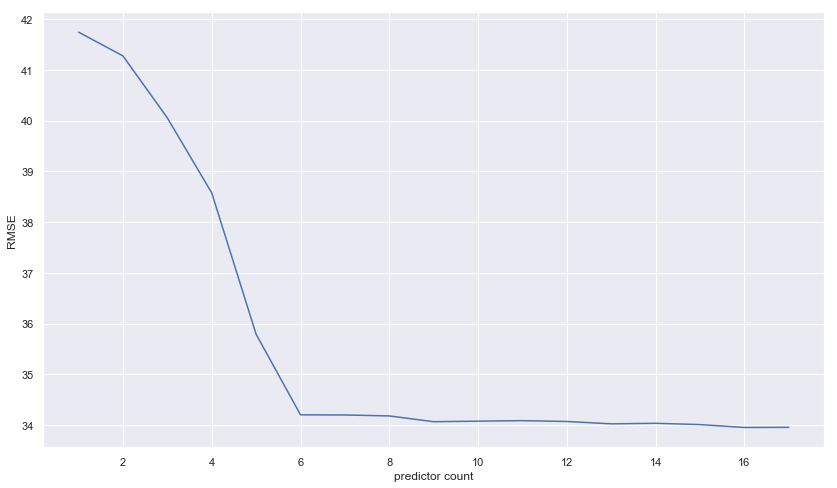

,predictor,selected
0,Intercept,True
1,C(maritl)[T.2. Married],True
2,C(maritl)[T.3. Widowed],True
3,C(maritl)[T.4. Divorced],False
4,C(maritl)[T.5. Separated],True
5,C(race)[T.2. Black],True
6,C(race)[T.3. Asian],True
7,C(race)[T.4. Other],True
8,C(jobclass)[T.2. Information],True
9,C(health)[T.2. >=Very Good],True


In [12]:
# Create features
f = 'year + education + cr(age, df=4) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'
X = pt.dmatrix(f , wage_df)
y = np.asarray(wage_df['wage'])
#display(X)

# Backward stepwise feature selection
estimator = LinearRegression(fit_intercept=False)
selector = RFECV(estimator, step=1, cv=10, scoring='neg_mean_squared_error')
selector = selector.fit(X, y)

# Best model stats
RMSEs_backward  = np.sqrt(np.abs(selector.grid_scores_))
predictor_count = np.arange(1, 1+len(RMSEs_backward))
print('Min RMSE            : {}'.format(min(RMSEs_backward)))
print('Best predictor count: {}'.format(np.sum(selector.support_)))

# Plot RMSE for each step
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(x='predictor count', y='RMSE', ax=ax, 
             data=pd.DataFrame({'RMSE': RMSEs_backward, 'predictor count': predictor_count}))
plt.show();

# Show selected features
display(HTML('<h4>Features selected</h4>'))
display(pd.DataFrame({'predictor': X.design_info.column_names,
                      'selected': selector.ranking_ == 1}))

Backward stepwise selects a model with all features except 'Divorced', reporting an RMSE of 33.97. A marked improvement on the best RMSE achieved for univariate regression of age with 4 degree polynomial: 39.8.

**Revision note:** Backward stepwise doesn't seem to be appropriately selecting the degrees of freedom for age. For example, when df=50 all degrees of freedom are selected with an RMSE of 34.05 for that model. The RMSE for a model with around 17 predictors is ~34.05, worse than when we observe above, suggesting that backward stepwise is unable to find the optimal degrees of freedom for age with this approach. 

I think the problem is that when we use patsy `cr()` command we specify the degrees of freedom at this point and the appropriate features are created. In the approach above I assumed that if we call `cr(ag, df=10)` then only use the first 5 resultant age featutes then that would be equivalent to cubic regression with df=5 – this assumption is fales, it would be true for polynomial features but not for spline features which presumable represent each knot.

**Note:** sklearn's RFECV functions used here for backward stepwise doesn't allow us to set the random seed used for k-fold splits, which means that there will be variance when trying to reproduce above results. I've observed this effect by running the above mult times. This is bad science, we really need a method that is reproducible.


### Approach 2 – Selection of optimal DOF for age by cross valiation, then backward stepwise treating age spline features as single feature

#### Step 1

Choose optimal degrees of freedom for age by holding all other predictors still whilst varying dof, then testing with cross validations.

In [13]:
def ols_cv(formula, X, y, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

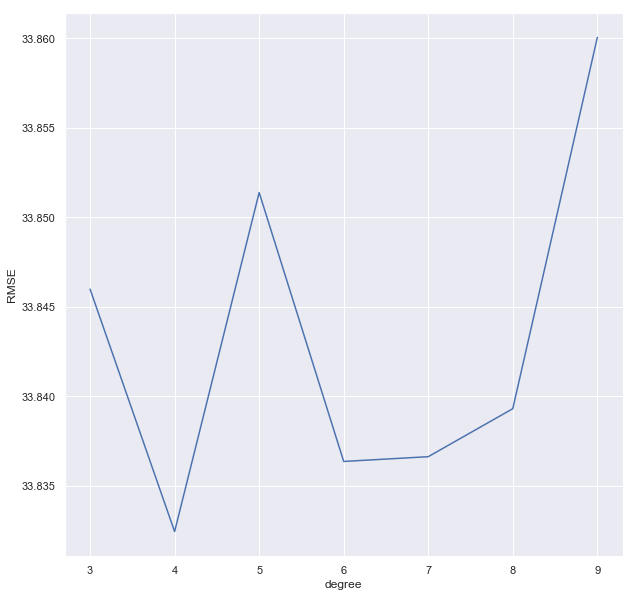

Min RMSE : 33.83243960258707
Degree   : 4


In [14]:
# Perform CV for increasing polynomial order
results = [] 
for d in np.arange(3,10):
    f = 'year + education + cr(age, df={}) + C(maritl) + C(race) + C(jobclass) + C(health) + C(health_ins)'.format(d)
    X = pt.dmatrix(f, wage_df)
    y = np.asarray(wage_df['wage'])
    results += [(ols_cv(f, X, y, 10)[0], d)]
    
# Plot the results
df = pd.DataFrame({'RMSE': [r[0] for r in results],
                   'degree': [r[1] for r in results]})   
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='degree', y='RMSE', data=df, color='b', ax=ax)
plt.show();

# Choose model
print('Min RMSE : {}'.format(min(results)[0]))
print('Degree   : {}'.format(min(results)[1]))

#### Step 2

Estimate best subset of features in each subset of p predictors using backward stepwise selection.

In [15]:
def backward_stepwise_patsy(predictors, response, data, scorer='ssr', results=[]):
    """Perform backward stepwise variable selection as described in
    An Introductions to Statistical Learning (p.209)
    Returns pandas dataframe object  with results for each step"""
    # List predictors that havent's been used so far
    p_all = predictors

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = '{} ~ {}'.format(response, '+'.join(p_all))
        model = smf.ols(formula=f, data=data).fit()
        # Begin backward stepwise recursion
        if scorer == 'ssr':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.ssr, p_all)])
        if scorer == 'rsquared_adj':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.rsquared_adj, p_all)])
        if scorer == 'bic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.bic, p_all)])
        if scorer == 'aic':
            return backward_stepwise_patsy(predictors, response, data, scorer, [(model.aic, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        scores = [r[0] for r in results]
        preds  = [r[1] for r in results]
        return pd.DataFrame({scorer: scores, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = '{} ~ {}'.format(response, '+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=data).fit()
        r     += [(model, p_test)]
    
    # Choose removal of predictor which yields best score
    if scorer == 'ssr':
        best_model = sorted(r, key=lambda tup: tup[0].ssr)[0]
        best_score = (best_model[0].ssr, best_model[1])
    elif scorer == 'rsquared_adj':
        best_model = sorted(r, key=lambda tup: tup[0].rsquared_adj)[-1]
        best_score = (best_model[0].rsquared_adj, best_model[1])        
    elif scorer == 'bic':
        best_model = sorted(r, key=lambda tup: tup[0].bic)[0]
        best_score = (best_model[0].bic, best_model[1]) 
    elif scorer == 'aic':
        best_model = sorted(r, key=lambda tup: tup[0].aic)[0]
        best_score = (best_model[0].aic, best_model[1]) 

    new_results = results + [best_score]
    # Recursive call to self
    return backward_stepwise_patsy(predictors, response, data, scorer, new_results)


def subset_analysis(df, scorer):
    """Renders results from forward_stepwise() and backward_stepwise()"""
    df['predictors_str'] = df['predictors'].astype(str)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.lineplot(x='predictors_str', y=scorer, data=df, sort=False, ax=ax)
    plt.xticks(rotation=90)
    plt.show();
    
    if scorer == 'rsquared_adj':
        display(df[df[scorer] ==  df[scorer].max()].drop('predictors_str', axis=1))
        return df
    else:
        display(df[df[scorer] ==  df[scorer].min()].drop('predictors_str', axis=1))
        return df

        
def ols_cv_patsy(formula, data, k):
    """Perform k-fold cross validation to return mean MSE score
    Expects formula as Patsy formula"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    y, X = pt.dmatrices(formula, wage_df)
    X_folds = np.array(np.array_split(X, k))
    y_folds = np.array(np.array_split(y, k))
    
    RMSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = np.delete(X_folds, f, 0).reshape(-1, X_folds.shape[-1])
        y_train = np.delete(y_folds, f, 0).reshape(-1, 1)
        
        # Fit model
        model = sm.OLS(y_train, X_train).fit()
        # Measure MSE
        y_hat = model.predict(X_test)
        RMSEs += [np.sqrt(metrics.mean_squared_error(y_test, y_hat))]
    return (np.mean(RMSEs), formula)

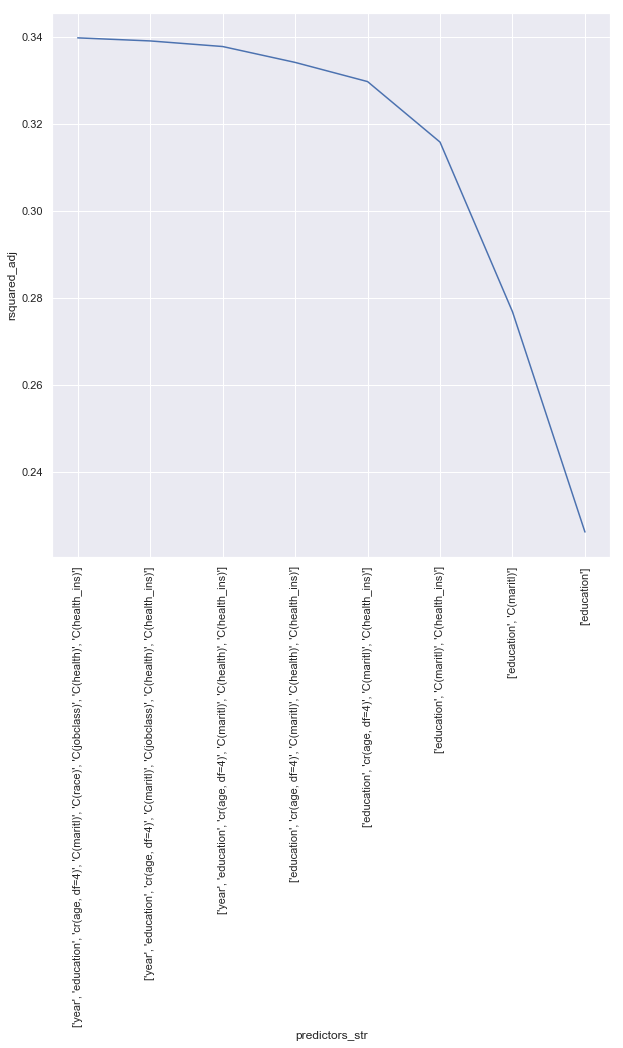

,rsquared_adj,predictors
0,0.339702,"[year, education, cr(age, df=4), C(maritl), C(..."


In [16]:
response = 'wage'
predictors = ['year', 
              'education', 
              'cr(age, df=4)', 
              'C(maritl)',
              'C(race)',
              'C(jobclass)',
              'C(health)',
              'C(health_ins)']


results = subset_analysis(backward_stepwise_patsy(predictors, response, wage_df, scorer='rsquared_adj'), 'rsquared_adj')

#### Step 3

Compare best models in each subset with 10-fold cross validation.

In [17]:
predictor_subsets = list(results['predictors'])
reponse = 'wage'
r = []
for p in predictor_subsets:
    f     = '{} ~ {}'.format(response, '+'.join(p))
    # Fit model
    r += [ols_cv_patsy(f, wage_df, 10)]
    

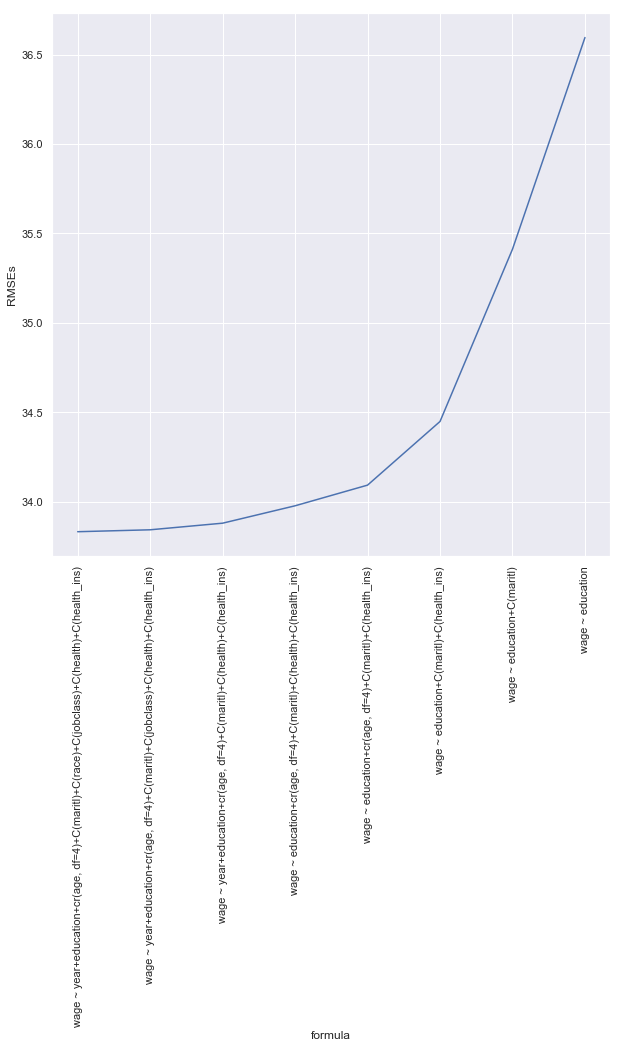

Min RMSE: 33.83243960258707
Model   : wage ~ year+education+cr(age, df=4)+C(maritl)+C(race)+C(jobclass)+C(health)+C(health_ins)


In [18]:
fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x='formula', y='RMSEs', ax=ax, sort=False,
             data=pd.DataFrame({'RMSEs': [i[0] for i in r], 'formula': [i[1] for i in r]}))
plt.xticks(rotation=90)
plt.show();

print('Min RMSE: {}'.format(min(r)[0]))
print('Model   : {}'.format(min(r)[1]))

We a arrive at a model that achives an RMSE CV score of 33.83, marginally lower than that achieved in approach 1 (33.97).

The selected model uses all features with 4 degrees of freedom for a cubic regression spline on age.

## 11. In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.

## Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient esti- mate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued un- til convergence—that is, until the coefficient estimates stop changing.

## We now try this out on a toy example.


At this point I start playing around with 3d visualisation, I don't know why...

Not relevant to this question, but leaving here because it is interesting.

In [19]:
x1 = np.arange(-5, 5, 1)
x2 = np.arange(-5, 5, 1)
xx1, xx2 = np.meshgrid(x1, x2, sparse=False)
X = np.asarray([xx1.flatten(), xx2.flatten()]).T
y = (2*xx1**3 + 5*xx2**2).flatten() + np.random.normal(0, 10, 100)

def plot_3d_b(yaw, pitch):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(X[:,0], X[:,1], y, linewidth=0.2, antialiased=True)

    # Rotate it
    ax.view_init(pitch, yaw)
    plt.show()    
    
interact(plot_3d_b, 
         yaw=widgets.FloatSlider(min=1, max=360, step=10, value=230),
         pitch=widgets.FloatSlider(min=1, max=360, step=10, value=20));

interactive(children=(FloatSlider(value=230.0, description='yaw', max=360.0, min=1.0, step=10.0), FloatSlider(…

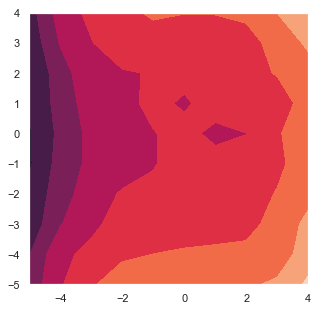

In [20]:
# Contour plot
fig = plt.figure(figsize=(5, 5))
plt.contourf(x1, x2, y.reshape(10,10));

### (a) Generate a response Y and two predictors X1 and X2, with n = 100.

In [21]:
np.random.seed(1)
x1  = np.random.normal(0, 1, 100)
x2  = np.random.normal(0, 1, 100)
eps = 0.1 * np.random.normal(0, 1, 100)

X = np.asarray([np.ones(100), x1, x2]).T
y = 0.2 + 2*x1 + 5*x2 + eps



### (c) Keeping $β_1$ fixed, fit the model 

$$y − β_1 X_1 = β_0 + β_2 X_2 + ε$$

Ordinary least squares regression is defined by the matrix operation:

$$\hat{β} = (X^T X)^{-1}X^T y$$

In [22]:
beta1 = 20
ya = y - (beta1*x1)
Xa = np.asarray([np.ones(100), x2]).T

# Fit using Ordinary Least Squares regression
beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
print(beta_hat)

beta2 = beta_hat[1]

[-0.65602756  3.47192688]


### (d) Keeping $β_2$ fixed, fit the model 

$y − β_2 X_2 = β_0 + β_1 X_1 + ε$

In [23]:
ya = y - (beta2*x2)
Xa = np.asarray([np.ones(100), x1]).T

beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
print(beta_hat)

#beta1 = beta_hat[1]

[0.42587836 2.14171377]


### (e) Write a for loop to repeat (c) and (d) 1,000 times. Report the estimates of βˆ0, βˆ1, and βˆ2 at each iteration of the for loop. Create a plot in which each of these values is displayed, with βˆ0, βˆ1, and βˆ2 each shown in a different color.

In [24]:
beta1 = 100

results= []
for i in range(20):
    # Keeping beta1 fixed, fit the model to estimate beta2
    ya = y - (beta1*x1)
    Xa = np.asarray([np.ones(100), x2]).T
    
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya 
    beta2 = beta_hat[1]
    
    # Keeping beta2 fixed, fit the model beta1
    ya = y - (beta2*x2)
    Xa = np.asarray([np.ones(100), x1]).T
    
    beta_hat = (np.linalg.inv((Xa.T @ Xa)) @ Xa.T) @ ya
    beta1 = beta_hat[1]
    beta0 = beta_hat[0]
    results += [[beta0, beta1, beta2]]

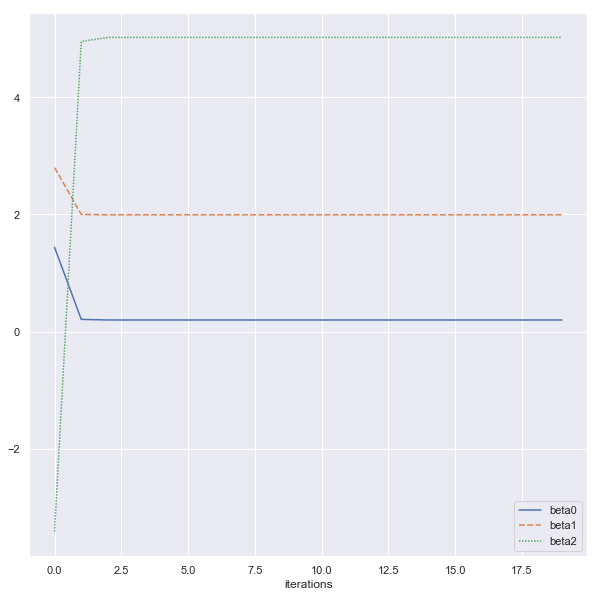

In [25]:
fig = plt.figure(figsize=(10, 10))
sns.lineplot(data=pd.DataFrame(np.asarray(results), columns=['beta0','beta1','beta2']))
plt.xlabel('iterations');

### (f) Compare your answer in (e) to the results of simply performing multiple linear regression to predict Y using X1 and X2. Use the abline() function to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

In [26]:
# A multivariate regression for ref
beta_hat = (np.linalg.inv((X.T @ X)) @ X.T) @ y
beta_hat

array([0.19802058, 1.99381028, 5.02183714])

In [27]:
# Plot comparison of results from backfitting and multivariate linear regression
backfit   = np.asarray(results)
multi_ols = np.ones([r.shape[0], r.shape[1]]) * beta_hat
data      = np.concatenate((backfit, multi_ols), axis=1)
cols = ['beta0_backfit','beta1_backfit','beta2_backfit', 'beta0_multi','beta1_multi','beta2_multi']
plot_df = pd.DataFrame(data, columns=cols)

fig = plt.figure(figsize=(10, 10))
sns.lineplot(data=plot_df)
plt.xlabel('iterations');
#plt.axhline(y=beta_hat[0], linestyle='--')

AttributeError: 'list' object has no attribute 'shape'

### (g) On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple re- gression coefficient estimates?

Two

### 12. This problem is a continuation of the previous exercise. In a toy example with p = 100, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting procedure. How many backfitting iterations are required in order to obtain a “good” approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [28]:
def gen_data(n, p):
    """Generate simulated data from normal distribution where:
    - n is number of observations
    - p is number of predictors
    
    Returns
    X, design matrix of predictors with bias variable
    y, response variable from linear model
    beta_true, the true coefficients of the linear model used to derive y from X
    beta_rand, a random vector of shape beta_true, useful as starting point for iterative estimatation
    """
    np.random.seed(1)
    # Generate 100 random observations for 100 predictors
    predictors = np.random.normal(0, 1, (n, p))
    # Add bias variable
    X = np.insert(predictors, 0, 1, axis=1)
    # Generate random beta coefficients
    beta_true = np.random.randint(0, 10, size=X.shape[1]).astype(np.float64)
    # Derive true y
    eps = 0.1* np.random.normal(0, 1, n)
    y = beta_true @ X.T + eps
    
    # Initalize beta at some random values
    beta_rand = list(np.random.randint(0, 10, size=X.shape[1]).astype(np.float64))
    
    return X, y, beta_true, beta_rand


def backfit(X, y, iterations:int, beta_ests:list):
    """Perform backfitting algorithm to recursively estimate
    beta parameters one at a time"""
    
    # Exit recursion
    if len(beta_ests) == iterations:
        return np.asarray(beta_ests)
    
    # Start recursion or iterate 
    beta_prev = copy.deepcopy(beta_ests[-1])
    beta_new  = np.zeros(len(beta_prev))
    
    # Perform one backfitting iteration to generate new set of estimates for all beta
    for j in  np.arange(1, X.shape[1]):
        # - Exclude predictors for which params are not being estimated in this pass (except intercept)
        # - Isolate predictors for which param is to be estimated in this pass
        # - Perform Ordinary Least Squares regression
        y_b = y - (np.delete(beta_prev[1:], j-1) @ np.delete(X[:, 1:], j-1, axis=1).T)
        X_b = X[:, [0,j]]
        beta_est = (np.linalg.inv((X_b.T @ X_b)) @ X_b.T) @ y_b
        
        # Save estimates, but include intercept estimate on first pass only
        if j == 1:
            beta_new[0] = beta_est[0]
            beta_new[1] = beta_est[1]
        else:
            beta_new[j] = beta_est[1]
    
    # Recur
    return backfit(X, y, iterations, beta_ests+[beta_new])


def backfit_plot(n, p, iterations):
    """Plot coefficient estimates for each iteration of backfitting for simulated data:
    - n is number of observations
    - p is number of predictors
    - iterations is number of backfitting iterations
    """
    # Gen simulated data
    X, y, beta_true, beta_rand = gen_data(n, p)
    
    beta_ests = backfit(X, y, iterations, [beta_rand])
    cols = ['x{}'.format(i) for i in range(p+1)]
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(p+1):
        # Plot estimated coefficient
        sns.lineplot(data=beta_ests[:, i]);
        # Plot true coefficient
        plt.axhline(y=beta_true[i], linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel('coefficients (β)')
    plt.show();
    #return beta_ests

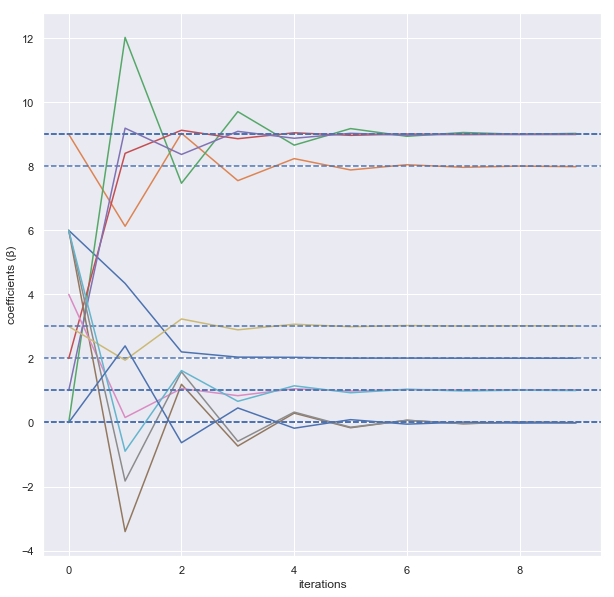

In [29]:
backfit_plot(n=100, p=10, iterations=10);

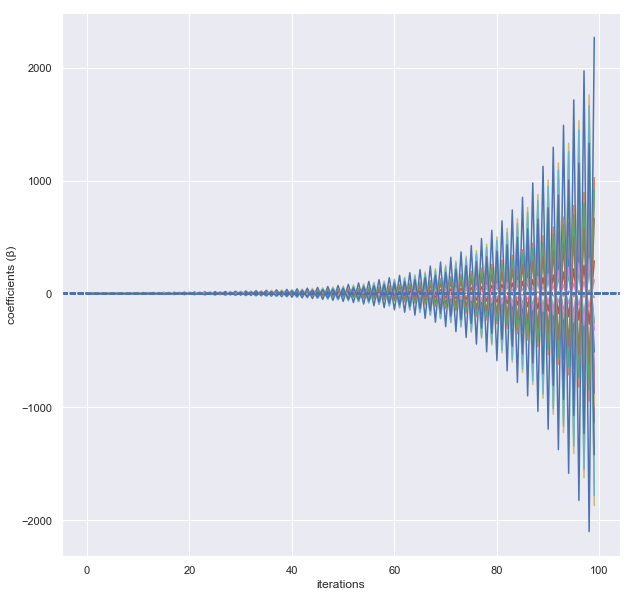

In [30]:
backfit_plot(n=100, p=20, iterations=100);

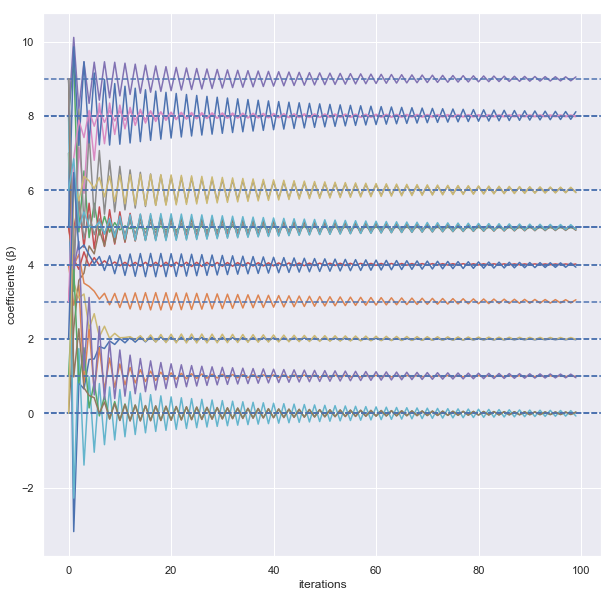

In [31]:
backfit_plot(n=110, p=20, iterations=100);

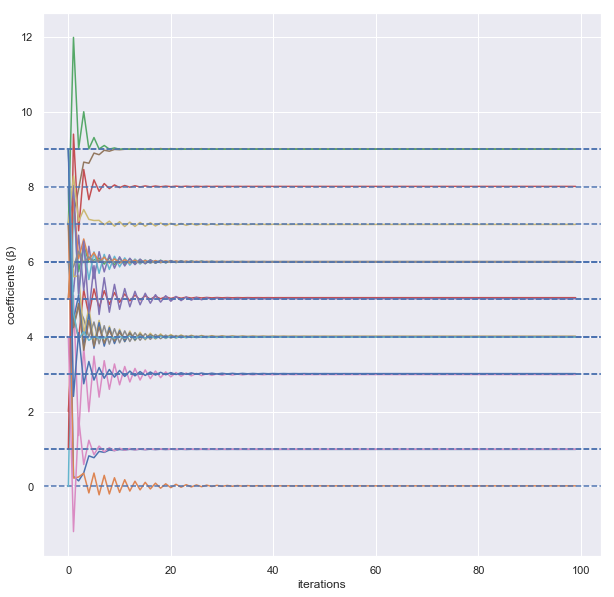

In [32]:
backfit_plot(n=120, p=20, iterations=100);

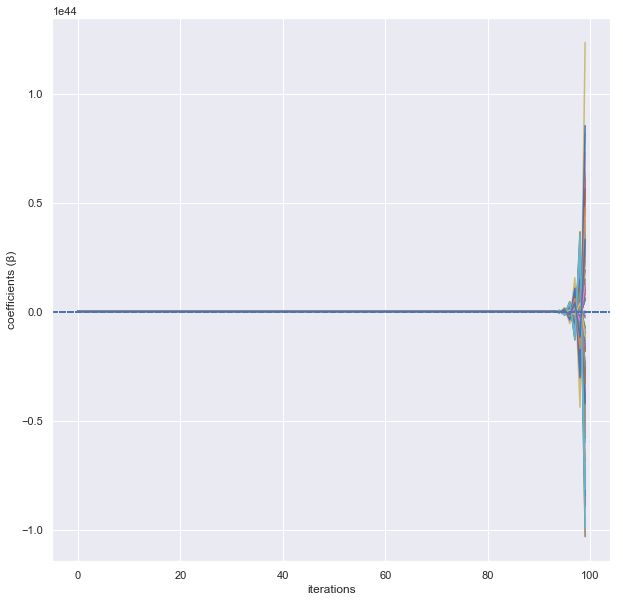

In [33]:
backfit_plot(n=100, p=100, iterations=100);

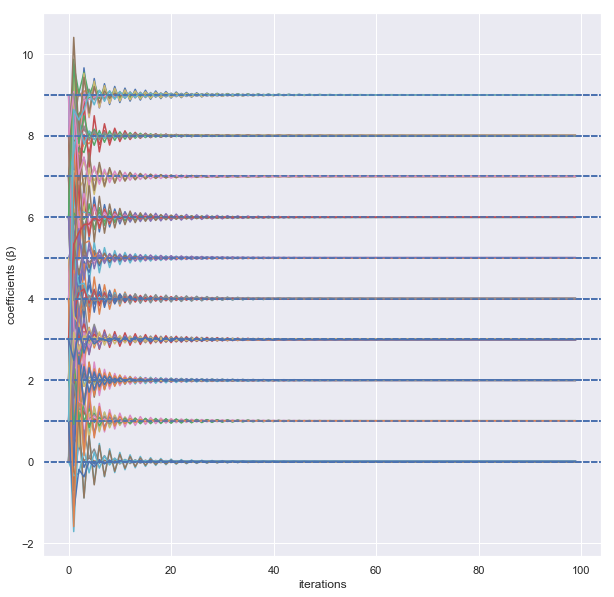

In [34]:
backfit_plot(n=650, p=100, iterations=100);

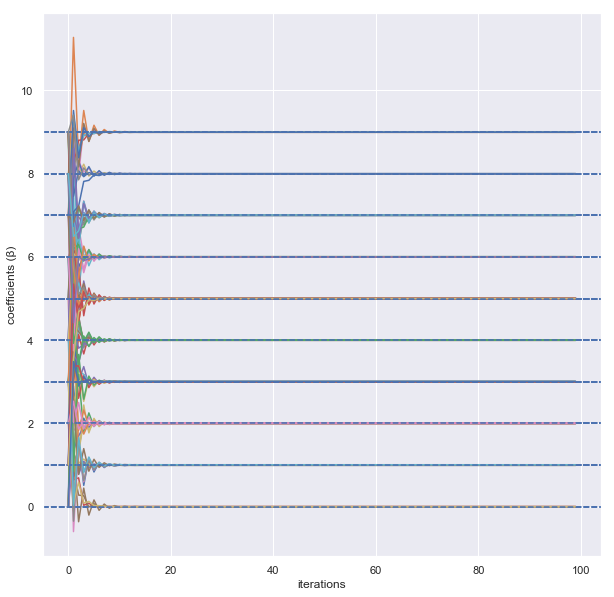

In [35]:
backfit_plot(n=1000, p=100, iterations=100);

**Comment:**

Above I've plotted the coefficient estimates at each iteration from backfitting with data simulated from linear models with various numbers of predictors and observations. On each plot horizontal dashed lines show the true coefficient values.

We can see that in some cases the backfitting estimates converge to the true value, and in some cases estimates are divergent.

Convergence is dependant on the number of predictors p AND the number of observation n. Convergence is not observed when n < p. The factor by which n must be greater than p in order for convergence to occur doesn't seem to be constant, seems to be in the range 1.2p-10p

Once the threshold of convergence is achieved, further increasing the ratio n:p serves to reduce the number of iterations required for a given level of convergence.

To get an intuition for this intercaiton its worth playing around with the sliders below. Start by increasing p until estimates start to converge, then increase n until convergence reoccurs.

In [40]:
interact(backfit_plot, 
         n=widgets.IntSlider(min=10, max=1000, step=20, value=100),
         p=widgets.IntSlider(min=2, max=100, step=5, value=10),
         iterations=widgets.IntSlider(min=10, max=20, step=10, value=10));

interactive(children=(IntSlider(value=100, description='n', max=1000, min=10, step=20), IntSlider(value=10, de…